In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score

#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import pydotplus
import time as time

## Reading Data

In [2]:
data = pd.read_csv("Cancer_Data.csv")
data.shape

(569, 33)

## Filtering and Splitting Data

In [3]:
data = data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1)
print(data.head())

rows = data[data.isnull().any(axis=1)]
cols= data.columns[data.isnull().any()]

if len(rows) == 0: 
    print('no more N/As')
    
if len(cols) == 0: 
    print('no more N/As')
    
print(data.shape)

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [4]:
data['diagnosis_dummy'] = 0
data.loc[data['diagnosis'] == 'M', 'diagnosis_dummy'] = 1

In [5]:
X = data.drop(columns = ['diagnosis', 'diagnosis_dummy'])
y = data['diagnosis_dummy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Classification Tree

#### Naive Model

In [8]:
model = DecisionTreeClassifier(random_state=1) 
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

Accuracy:  93.85964912280701
ROC-AUC:  0.9265873015873016
Precision:  0.9487179487179487
Recall:  0.8809523809523809


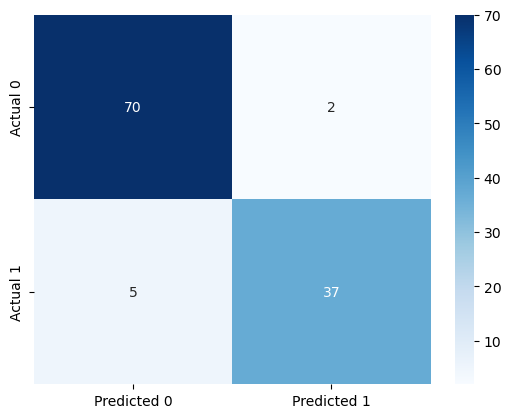

In [9]:
# Performance metrics computation 

#Computing the accuracy
y_pred = model.predict(X_test)
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

#### Hyperparameter Tuning

In [10]:
#Defining the object to build a regression tree
model = DecisionTreeClassifier(random_state=1) 

#Fitting the regression tree to the data
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [11]:
# Maximum number of leaves
model.get_n_leaves()

14

In [12]:
# Maximum depth
model.get_depth()

5

In [15]:
param_grid = {    
    'max_depth': range(2,5),
    'max_leaf_nodes': range(2,14),
    'max_features': range(1, 32)
}

#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=5)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['precision','recall'], 
                           refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 1116 candidates, totalling 5580 fits
Train accuracy : 0.919
Test accuracy : 0.930
Best accuracy Through Grid Search : 0.953
Best params for recall
{'max_depth': 2, 'max_features': 5, 'max_leaf_nodes': 3}


In [16]:
model = DecisionTreeClassifier(random_state=1, max_depth = 2, max_leaf_nodes=3, max_features=5).fit(X_train, y_train)

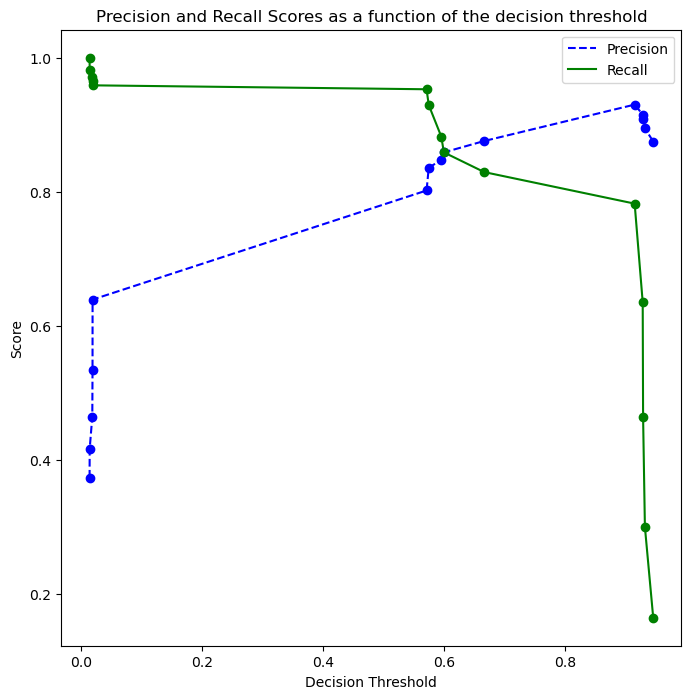

In [19]:
cross_val_ypred = cross_val_predict(DecisionTreeClassifier(random_state=1, max_depth = 2, 
                                                        max_leaf_nodes=3, max_features=5), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [20]:
np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)

array([[0.01456311, 0.37362637, 1.        ],
       [0.01470588, 0.41645885, 0.98235294],
       [0.01904762, 0.46478873, 0.97058824],
       [0.01941748, 0.53420195, 0.96470588],
       [0.0195122 , 0.63921569, 0.95882353],
       [0.57142857, 0.8019802 , 0.95294118],
       [0.575     , 0.83597884, 0.92941176],
       [0.59574468, 0.84745763, 0.88235294],
       [0.6       , 0.85882353, 0.85882353],
       [0.66666667, 0.8757764 , 0.82941176],
       [0.91525424, 0.93006993, 0.78235294],
       [0.92857143, 0.91525424, 0.63529412],
       [0.92920354, 0.90804598, 0.46470588],
       [0.93220339, 0.89473684, 0.3       ],
       [0.94594595, 0.875     , 0.16470588]])

Accuracy:  92.98245614035088
ROC-AUC:  0.9632936507936507
Precision:  0.8695652173913043
Recall:  0.9523809523809523


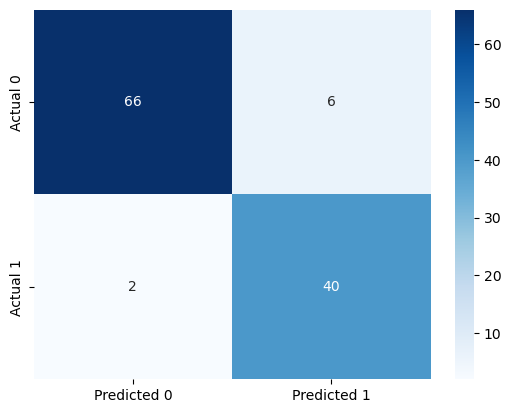

In [21]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.57142857 # maximize recall with decent precision

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

#### Feature Importances

## Bagging

#### Naive Bagging

In [23]:
#Bagging the results of 10 decision trees to predict car price
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=150, random_state=1,
                        n_jobs=-1).fit(X_train, y_train)

Accuracy:  95.6140350877193
ROC-AUC:  0.9770171957671958
Precision:  1.0
Recall:  0.8809523809523809


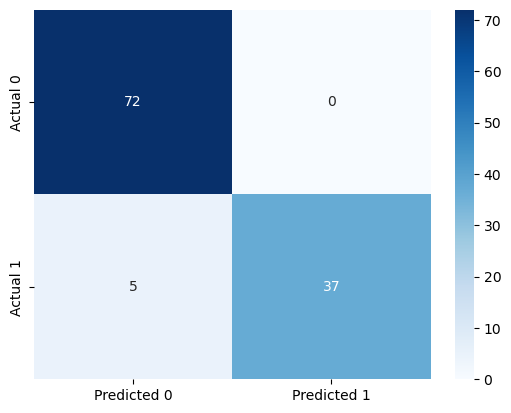

In [24]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.57142857

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

#### Tuning Hyperparameters

In [25]:
params = {'base_estimator': [DecisionTreeClassifier(random_state = 1)],#Comparing bagging with a linear regression model as well
          'n_estimators': [150,200,250],
          'max_samples': [0.5, 0.75, 1.0],
          'max_features': [0.5, 0.75, 1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_classifier_grid = GridSearchCV(BaggingClassifier(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1,
                                      scoring = ['precision', 'recall'], refit='recall')
bagging_classifier_grid.fit(X_train, y_train)

print('Train accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%bagging_classifier_grid.best_score_)
print('Best Parameters : ',bagging_classifier_grid.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Train accuracy : 1.000
Test accuracy : 0.956
Best accuracy Through Grid Search : 0.942
Best Parameters :  {'base_estimator': DecisionTreeClassifier(random_state=1), 'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 0.75, 'n_estimators': 250}


In [26]:
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1), n_estimators=250, 
                          random_state=1,max_features=0.5,
                        max_samples=0.75,n_jobs=-1,bootstrap=False,bootstrap_features=True).fit(X_train, y_train)

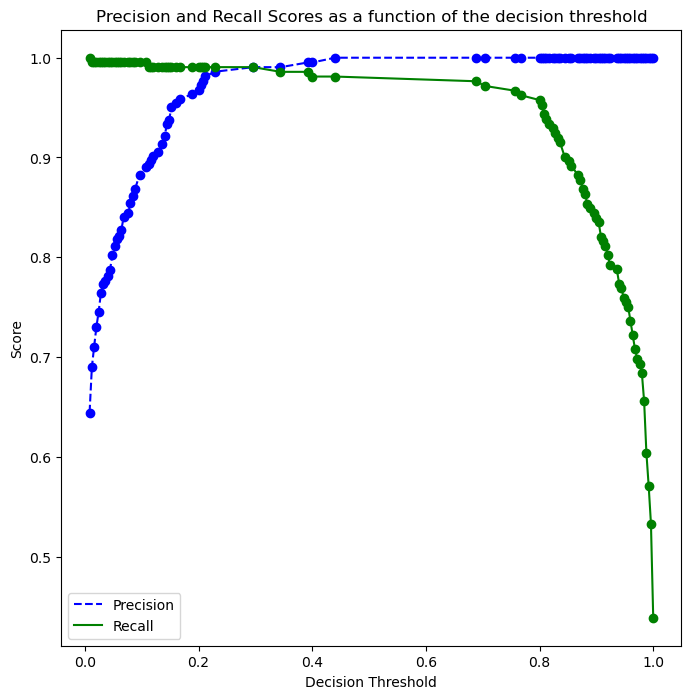

In [27]:
ypred = model.predict_proba(X)[:,1]
p, r, thresholds = precision_recall_curve(y, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [28]:
ypred = model.oob_decision_function_[:,1]
p, r, thresholds = precision_recall_curve(y_train, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

AttributeError: 'BaggingClassifier' object has no attribute 'oob_decision_function_'

In [29]:
# Thresholds with precision and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_80 = all_thresholds[all_thresholds[:,2]>0.8,:]
# As the values in 'recall_more_than_80' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_80

array([[0.008     , 0.6443769 , 1.        ],
       [0.012     , 0.68954248, 0.99528302],
       [0.016     , 0.71043771, 0.99528302],
       [0.02      , 0.73010381, 0.99528302],
       [0.024     , 0.74558304, 0.99528302],
       [0.028     , 0.76449275, 0.99528302],
       [0.032     , 0.77289377, 0.99528302],
       [0.036     , 0.77573529, 0.99528302],
       [0.04      , 0.78148148, 0.99528302],
       [0.044     , 0.78731343, 0.99528302],
       [0.048     , 0.80228137, 0.99528302],
       [0.052     , 0.81153846, 0.99528302],
       [0.056     , 0.81782946, 0.99528302],
       [0.06      , 0.82101167, 0.99528302],
       [0.064     , 0.82745098, 0.99528302],
       [0.068     , 0.84063745, 0.99528302],
       [0.076     , 0.844     , 0.99528302],
       [0.08      , 0.85425101, 0.99528302],
       [0.084     , 0.86122449, 0.99528302],
       [0.088     , 0.86831276, 0.99528302],
       [0.096     , 0.88284519, 0.99528302],
       [0.108     , 0.89029536, 0.99528302],
       [0.

Accuracy:  95.6140350877193
ROC-AUC:  0.9846230158730158
Precision:  0.9512195121951219
Recall:  0.9285714285714286


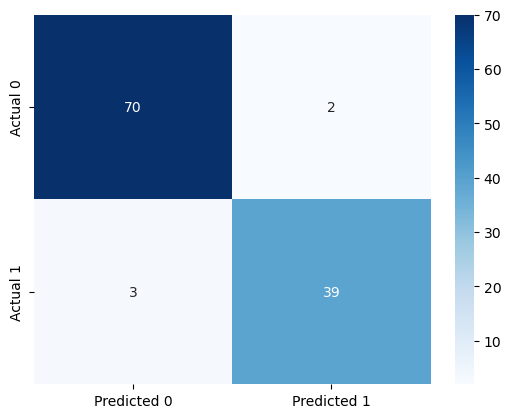

In [32]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.296 # good precision and recall

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

#### Finer Grid Search

In [34]:
params = {'base_estimator': [DecisionTreeClassifier(random_state = 1)],#Comparing bagging with a linear regression model as well
          'n_estimators': [230, 250, 270],
          'max_samples': [0.65, 0.75, 0.85],
          'max_features': [0.3, 0.5, 0.7],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_classifier_grid = GridSearchCV(BaggingClassifier(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1,
                                      scoring = ['precision', 'recall'], refit='recall')
bagging_classifier_grid.fit(X_train, y_train)

print('Train accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%bagging_classifier_grid.best_score_)
print('Best Parameters : ',bagging_classifier_grid.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Train accuracy : 1.000
Test accuracy : 0.956
Best accuracy Through Grid Search : 0.942
Best Parameters :  {'base_estimator': DecisionTreeClassifier(random_state=1), 'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 0.75, 'n_estimators': 230}


In [35]:
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1), n_estimators=230, 
                          random_state=1,max_features=0.5,
                        max_samples=0.75,n_jobs=-1,bootstrap=False,bootstrap_features=True).fit(X_train, y_train)

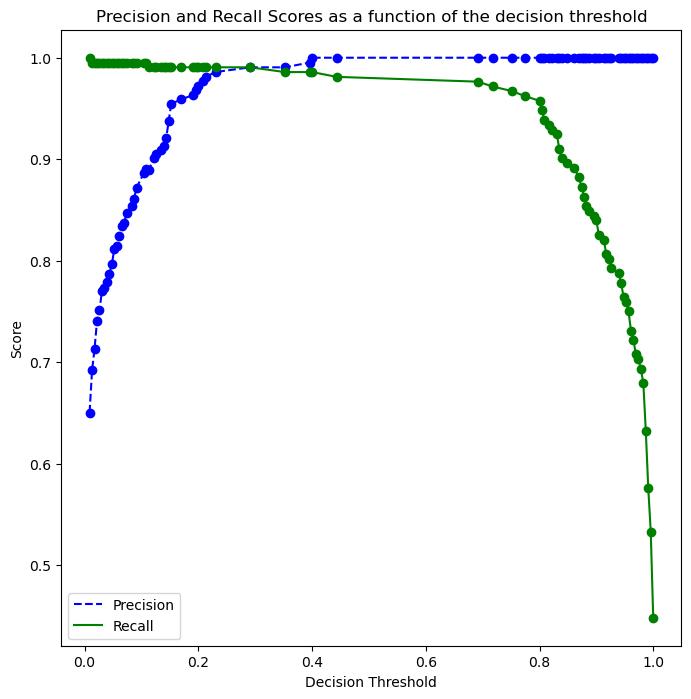

In [36]:
ypred = model.predict_proba(X)[:,1]
p, r, thresholds = precision_recall_curve(y, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [37]:
ypred = model.oob_decision_function_[:,1]
p, r, thresholds = precision_recall_curve(y_train, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

AttributeError: 'BaggingClassifier' object has no attribute 'oob_decision_function_'

In [38]:
# Thresholds with precision and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_80 = all_thresholds[all_thresholds[:,2]>0.8,:]
# As the values in 'recall_more_than_80' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_80

array([[0.00869565, 0.65030675, 1.        ],
       [0.01304348, 0.69180328, 0.99528302],
       [0.0173913 , 0.71283784, 0.99528302],
       [0.02173913, 0.74035088, 0.99528302],
       [0.02608696, 0.75088968, 0.99528302],
       [0.03043478, 0.77007299, 0.99528302],
       [0.03478261, 0.77289377, 0.99528302],
       [0.03913043, 0.77859779, 0.99528302],
       [0.04347826, 0.78731343, 0.99528302],
       [0.04782609, 0.79622642, 0.99528302],
       [0.05217391, 0.81153846, 0.99528302],
       [0.05652174, 0.81467181, 0.99528302],
       [0.06086957, 0.82421875, 0.99528302],
       [0.06521739, 0.83399209, 0.99528302],
       [0.06956522, 0.83730159, 0.99528302],
       [0.07391304, 0.84738956, 0.99528302],
       [0.0826087 , 0.85425101, 0.99528302],
       [0.08695652, 0.86122449, 0.99528302],
       [0.09130435, 0.87190083, 0.99528302],
       [0.10434783, 0.88655462, 0.99528302],
       [0.10869565, 0.89029536, 0.99528302],
       [0.11304348, 0.88983051, 0.99056604],
       [0.

Accuracy:  95.6140350877193
ROC-AUC:  0.9849537037037037
Precision:  0.9512195121951219
Recall:  0.9285714285714286


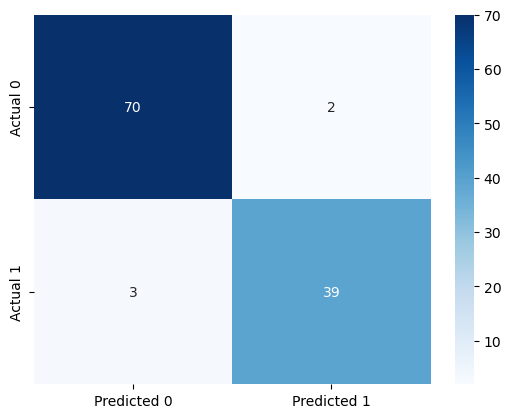

In [39]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.29130435

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');